## Final Project Submission

Please fill out:
* Student name: Scott Libby, Ansel Vallejo
* Student pace: full time
* Scheduled project review date/time: 05/16/2023
* Instructor name: David E.

In [1]:
import pandas as pd
import sqlite3
from scipy.stats import linregress
import matplotlib.pyplot as plt
import gzip
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'zippedData/im.db'
conn = sqlite3.connect(path)

cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

table_names = cur.fetchall() # Fetch the result and store it in table_names
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [3]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
rt_reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='unicode_escape')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [4]:
# Read the zipped file into a dataframe with gzip
with gzip.open('zippedData/tmdb.movies.csv.gz', 'rb') as f:
    tmdb_movies = pd.read_csv(f)

# Lowercase all object columns
for col in tmdb_movies.select_dtypes(include=['object']):
    tmdb_movies[col] = tmdb_movies[col].str.lower()

# Rename column    
tmdb_movies = tmdb_movies.rename(columns={'original_title': 'movie'})
# Remove brackets from 'genre_ids'
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].str.replace('[', '').str.replace(']', '')
# Remove unnecessary characters from dataframe, and clone into a new 'tmdb_moviesCLEAN'
tmdb_moviesCLEAN = tmdb_movies.applymap(lambda x: str(x).replace(',', '').replace('$', ''))

# Define a dictionary to match genre ID numbers to respective names
genre_id_mapping = {
    '28': 'action',
    '12': 'adventure',
    '16': 'animation',
    '35': 'comedy',
    '80': 'crime',
    '99': 'documentary',
    '18': 'drama',
    '10751': 'family',
    '14': 'fantasy',
    '36': 'history',
    '27': 'horror',
    '10402': 'music',
    '9648': 'mystery',
    '878': 'science fiction',
    '10770': 'tv movie',
    '53': 'thriller',
    '10752': 'war',
    '37': 'western'
}

# Replace genre ID numbers with genre names in the 'genre_ids' column
for genre_id, genre_name in genre_id_mapping.items():
    tmdb_moviesCLEAN['genre_ids'] = tmdb_moviesCLEAN['genre_ids'].str.replace(genre_id, genre_name)
tmdb_moviesCLEAN.rename(columns={'movie': 'movieNAME'}, inplace=True)
tmdb_moviesCLEAN

,Unnamed: 0,genre_ids,id,original_language,movieNAME,popularity,release_date,title,vote_average,vote_count
0,0,adventure fantasy family,12444,en,harry potter and the deathly hallows: part 1,33.533,2010-11-19,harry potter and the deathly hallows: part 1,7.7,10788
1,1,fantasy adventure animation family,10191,en,how to train your dragon,28.734,2010-03-26,how to train your dragon,7.7,7610
2,2,adventure action science fiction,10138,en,iron man 2,28.515,2010-05-07,iron man 2,6.8,12368
3,3,animation comedy family,862,en,toy story,28.005,1995-11-22,toy story,7.9,10174
4,4,action science fiction adventure,27205,en,inception,27.92,2010-07-16,inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,horror drama,488143,en,laboratory conditions,0.6,2018-10-13,laboratory conditions,0.0,1
26513,26513,drama thriller,485975,en,_exhibit_84xxx_,0.6,2018-05-01,_exhibit_84xxx_,0.0,1
26514,26514,fantasy action adventure,381231,en,the last one,0.6,2018-10-01,the last one,0.0,1
26515,26515,family adventure action,366854,en,trailer made,0.6,2018-06-22,trailer made,0.0,1


In [5]:
# Clone a new GENRES7 for further exploration
GENRES7 = tmdb_moviesCLEAN[['movieNAME', 'genre_ids']].copy()

In [6]:
# Define a dictionary to match genres to
genre_id_mapping = {
    '28': 'action',
    '12': 'adventure',
    '16': 'animation',
    '35': 'comedy',
    '80': 'crime',
    '99': 'documentary',
    '18': 'drama',
    '10751': 'family',
    '14': 'fantasy',
    '36': 'history',
    '27': 'horror',
    '10402': 'music',
    '9648': 'mystery',
    '878': 'science fiction',
    '10770': 'tv movie',
    '53': 'thriller',
    '10752': 'war',
    '37': 'western' }
# Split these genre_ids column into a list of strings
GENRES7['genre_ids'] = GENRES7['genre_ids'].str.split('|')

# Add a new column for each genre in the mapping
for genre_id, genre_name in genre_id_mapping.items():
    GENRES7[genre_name] = GENRES7['genre_ids'].apply(lambda x: genre_id in x).astype(int)
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,science fiction,tv movie,thriller,war,western
0,harry potter and the deathly hallows: part 1,[adventure fantasy family],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,how to train your dragon,[fantasy adventure animation family],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,iron man 2,[adventure action science fiction],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,toy story,[animation comedy family],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,inception,[action science fiction adventure],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,[horror drama],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26513,_exhibit_84xxx_,[drama thriller],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26514,the last one,[fantasy action adventure],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26515,trailer made,[family adventure action],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Remove some punctuation, and replace spaces with a verticle bar 
GENRES7['genre_ids'] = GENRES7['genre_ids'].astype(str).str.replace('[','').str.replace(']','').str.replace(' ','|').str.replace("'", "").str.replace(",", "")

# Counting Genres

In [8]:
# Make a function to count total genres per movie, by counting the spaces between genres, then adding 1 to account
def count_genres(genre_string):
    if genre_string is None:
        return 0
    else:
        return genre_string.count('|') + 1
# Run this new function on the 'genre_ids' column, then save the result in a new 'genre_total' column
GENRES7['genre_total'] = GENRES7['genre_ids'].apply(count_genres)

In [9]:
GENRES7['genre_ids'] = GENRES7['genre_ids'].str.split('|')

# Iterate over the genre columns and transport the genre string values
for genre_id, genre_name in genre_id_mapping.items():
    GENRES7[genre_name] = 0
    GENRES7.loc[GENRES7['genre_ids'].apply(lambda x: genre_id in x), genre_name] = 1
GENRES7  

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,"[adventure, fantasy, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,"[fantasy, adventure, animation, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,"[adventure, action, science, fiction]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,"[animation, comedy, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,inception,"[action, science, fiction, adventure]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,"[horror, drama]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26513,_exhibit_84xxx_,"[drama, thriller]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26514,the last one,"[fantasy, action, adventure]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
26515,trailer made,"[family, adventure, action]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [10]:
genre_order = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'science fiction', 'tv movie', 'thriller', 'war', 'western']

# Create a dictionary to map genre names to integer values
genre_int_mapping = {genre_name: index+1 for index, genre_name in enumerate(genre_order)}

# Iterate over the genre columns and assign integer values based on the substring in the genre_ids column
for genre_name in genre_order:
    GENRES7[genre_name] = 0

for index, row in GENRES7.iterrows():
    genre_list = row['genre_ids']
    for genre in genre_list:
        if genre in genre_int_mapping:
            genre_int = genre_int_mapping[genre]
            genre_name = genre_order[genre_int-1]
            GENRES7.at[index, genre_name] = genre_int

In [11]:
GENRES7 = GENRES7.drop_duplicates(subset='movieNAME', keep='first')
GENRES7 = GENRES7.reset_index(drop=True)
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,"[adventure, fantasy, family]",0,2,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,"[fantasy, adventure, animation, family]",0,2,3,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,"[adventure, action, science, fiction]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,"[animation, comedy, family]",0,0,3,4,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3
4,inception,"[action, science, fiction, adventure]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24813,laboratory conditions,"[horror, drama]",0,0,0,0,0,0,7,0,...,0,11,0,0,0,0,0,0,0,2
24814,_exhibit_84xxx_,"[drama, thriller]",0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,16,0,0,2
24815,the last one,"[fantasy, action, adventure]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
24816,trailer made,"[family, adventure, action]",1,2,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3


In [12]:
genre_columns = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'science fiction', 'tv movie', 'war', 'western']
new_GENRES= GENRES7[genre_columns]

In [13]:
# Add total integer value counts for each genre, and assign the new value to a new variable
columns_to_plot = [col for col in new_GENRES.columns if new_GENRES[col].sum() > 0]
genres_to_plot = new_GENRES[columns_to_plot].sum().reset_index()
genres_to_plot.columns = ['genre', 'count']

# Plot total genre counts

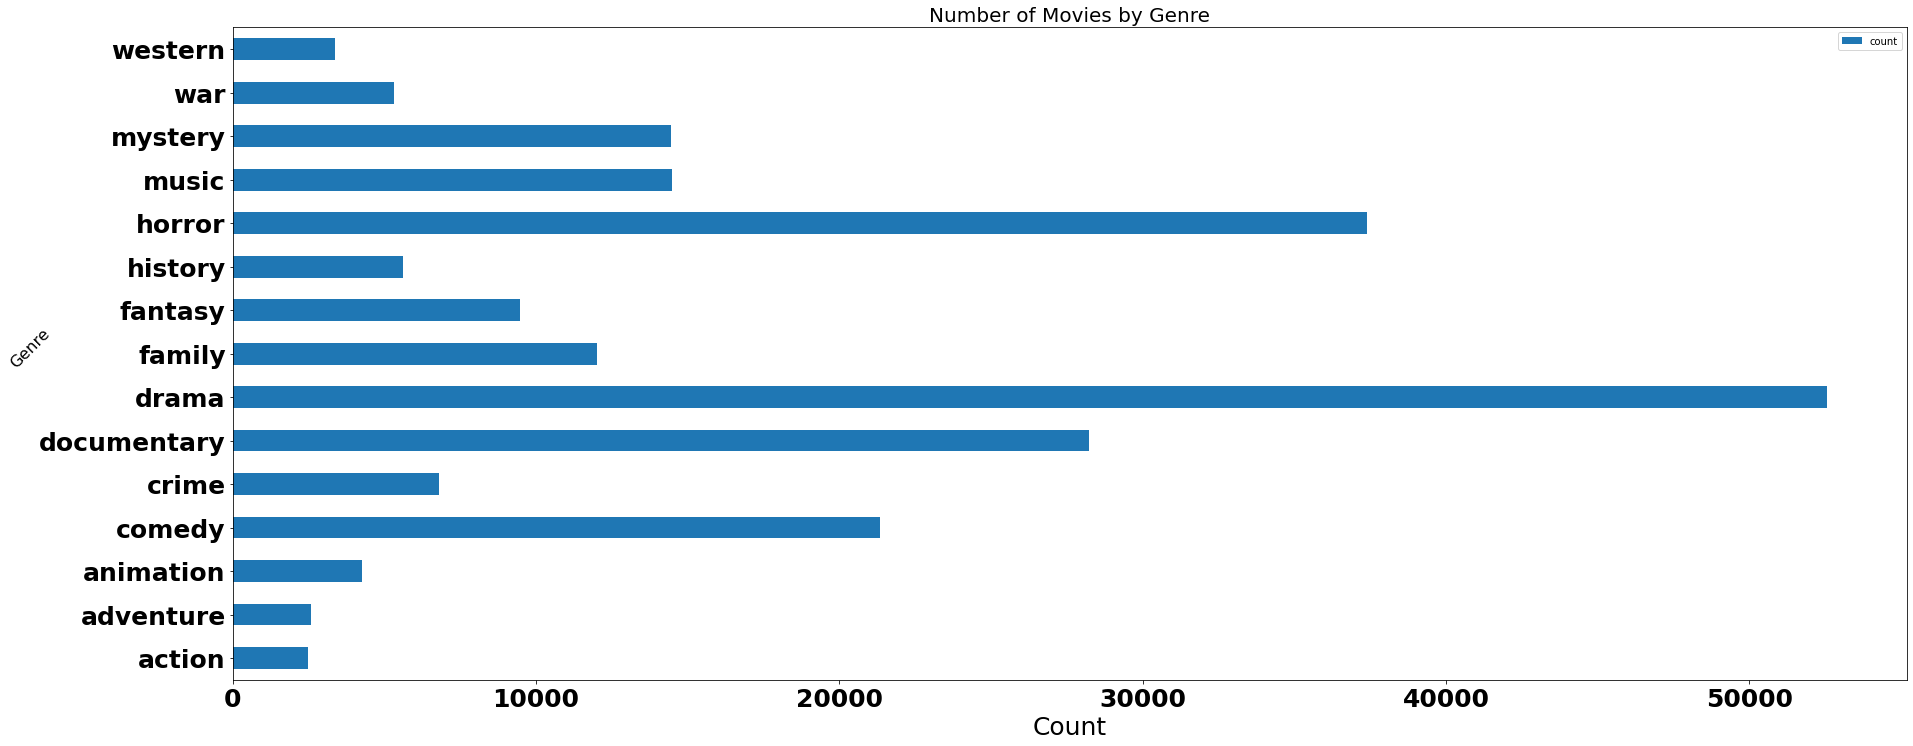

In [14]:
fig, ax = plt.subplots(figsize=(30, 12))  # Swap the figsize dimensions

genres_to_plot.plot.barh(y='count', x='genre', ax=ax, rot=0)

ax.set_xlabel("Count", fontsize=25)  # Swap x and y labels
ax.set_ylabel("Genre", fontsize=25)  # Swap x and y labels
ax.set_ylabel("Genre", fontsize=16, rotation=45)

ax.set_title("Number of Movies by Genre", fontsize=20)

plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=25, fontweight='bold')

plt.show()

# Calculating the ROI for TOP 3 Genres

## Pull the initial datasets

In [15]:
# We'll be cleaning and pulling a table from the database for this
movie_basics=pd.read_sql("""SELECT * FROM movie_basics ;""", conn)
movie_basics = movie_basics.rename(columns={'primary_title': 'movie'})
movie_basics = movie_basics.dropna(subset=['genres'])

In [16]:
# And we'll be cleaning and pulling coumns from the movie_budgets zipped dataset
with gzip.open('zippedData/tn.movie_budgets.csv.gz', 'rb') as f:
    movie_budgets = pd.read_csv(f)
for col in movie_budgets.select_dtypes(include=['object']):
    movie_budgets[col] = movie_budgets[col].str.lower()
    movie_budgetsCLEAN = movie_budgets.applymap(lambda x: str(x).replace(',', '').replace('$', ''))

## Start with Drama

In [17]:
# Select rows from movie_basics DataFrame where the 'genres' column contains 'Drama', store in new 'Drama_df'
Drama_df = movie_basics[movie_basics['genres'].str.contains('Drama', case=False)]
# Keep only the 'movie' and 'genres' columns in 'Drama_df'
Drama_df = Drama_df.loc[:, ['movie', 'genres']]
# Define a function to keep only the 'Drama' genre 
def keep_only_GENRE(genres):
    genre_list = genres.split(',')
    if 'Drama' in genre_list:
        return 'Drama'
    else:
        return ','.join(genre_list)

# Apply the keep_only_GENRE function to the 'genres' column in Drama_df
Drama_df['genres'] = Drama_df['genres'].apply(keep_only_GENRE)
# Convert genres and movies to lowercase
Drama_df[['genres', 'movie']] = Drama_df[['genres', 'movie']].apply(lambda x: x.str.lower())
Drama_df

,movie,genres
0,sunghursh,drama
1,one day before the rainy season,drama
2,the other side of the wind,drama
3,sabse bada sukh,drama
4,the wandering soap opera,drama
...,...,...
146124,the holden family plan,drama
146132,the last white witch,drama
146135,the rehearsal,drama
146137,safeguard,drama


In [18]:
# Inner join Drama_df with movie_budgetsCLEAN on 'movie'
Drama_cost = Drama_df.merge(movie_budgetsCLEAN[['movie', 'production_budget']], on='movie', how='inner')
# Convert 'production_budget' values to integer type for necessary calculations
Drama_cost['production_budget'] = Drama_cost['production_budget'].astype(int)

### Calculate the average production cost

In [19]:
Drama_cost_mean = Drama_cost['production_budget'].mean()
Drama_cost_mean

23541712.281437125

### Calculate the average total profit

In [20]:
Drama_gain = Drama_df.merge(movie_budgetsCLEAN[['movie', 'worldwide_gross']], on='movie', how='inner')
Drama_gain['worldwide_gross'] = Drama_gain['worldwide_gross'].astype('int64')
Drama_gain

,movie,genres,worldwide_gross
0,on the road,drama,9313302
1,on the road,drama,9313302
2,on the road,drama,9313302
3,on the road,drama,9313302
4,the secret life of walter mitty,drama,187861183
...,...,...,...
1832,molly,drama,17396
1833,chicago,drama,306770545
1834,the blue bird,drama,887000
1835,snow white and the seven dwarfs,drama,184925486


In [21]:
Drama_gain_mean= Drama_gain['worldwide_gross'].mean()
Drama_gain_mean

59248407.18726184

### Calculate the average ROI

In [22]:
# Calculate by coding the 'ROI' financial metric to the newly made dataframes
Drama_roi = ((Drama_gain_mean - Drama_cost_mean) / Drama_cost_mean) * 100
Drama_roi

151.6741623504583

#### Plotting the ROI

In [23]:
# Create a new dictionary containing data from the previously declared Drama dataframes
Drama_data = {'Genre': ['Drama'],
        'Average Cost': [Drama_cost_mean],
        'Average Gain': [Drama_gain_mean],}
# Then, convert dictionary to dataframe with Pandas
Drama_data = pd.DataFrame({'Category': ['Average Cost', 'Average Gain'], 'Value': [Drama_cost_mean, Drama_gain_mean]})

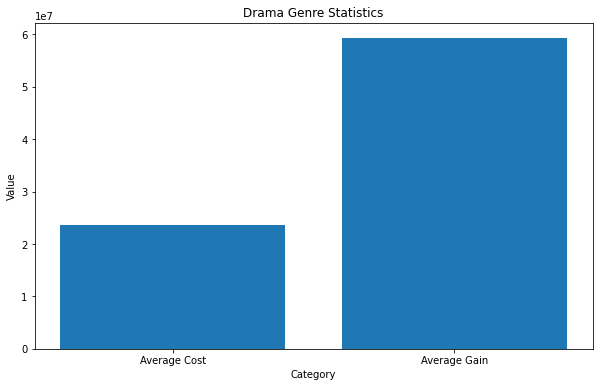

In [24]:
# Plot the ROI visual result, for highly expert understanding, comprehensible by any executive or shareholder
plt.figure(figsize=(10, 6))
plt.bar(Drama_data['Category'], Drama_data['Value'])
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Drama Genre Statistics')
plt.show()

## Next is the Horror Genre

### The Code Exists now, so We'll Replace 'Drama' with 'Horror'

In [25]:
Horror_df = movie_basics[movie_basics['genres'].str.contains('Horror', case=False)]
Horror_df = Horror_df.loc[:, ['movie', 'genres']]
def keep_only_GENRE(genres):
    genre_list = genres.split(',')
    if 'Horror' in genre_list:
        return 'Horror'
    else:
        return ','.join(genre_list)

Horror_df['genres'] = Horror_df['genres'].apply(keep_only_GENRE)
Horror_df['genres'] = Horror_df['genres'].str.lower()
Horror_df['movie'] = Horror_df['movie'].str.lower()
Horror_df

,movie,genres
6,bigfoot,horror
39,the wicker tree,horror
51,the evil within,horror
97,the possession,horror
101,caleuche: el llamado del mar,horror
...,...,...
146054,the curse of eve,horror
146055,badmen with a good behavior,horror
146062,scream returns,horror
146064,american terror story,horror


In [26]:
horror_cost = Horror_df.merge(movie_budgetsCLEAN[['movie', 'production_budget']], on='movie', how='inner')
horror_cost['production_budget'] = horror_cost['production_budget'].astype(int)

#### Drop movies with budgets less than 20k, to account for ROI anomalies like the movie "Paranormal Activity"

In [27]:
horror_cost = horror_cost[horror_cost['production_budget'] >= 20000]

In [28]:
horror_cost_mean = horror_cost['production_budget'].mean()
horror_cost_mean

18895964.669082124

In [29]:
horror_gain = Horror_df.merge(movie_budgetsCLEAN[['movie', 'worldwide_gross']], on='movie', how='inner')
horror_gain['worldwide_gross'] = horror_gain['worldwide_gross'].astype('int64')
horror_gain

,movie,genres,worldwide_gross
0,the possession,horror,82925064
1,the crazies,horror,56445534
2,house at the end of the drive,horror,0
3,piranha 3d,horror,83660160
4,rings,horror,82917283
...,...,...,...
413,sugar town,horror,178095
414,inferno,horror,219519367
415,kidnap,horror,34836080
416,into the woods,horror,213116401


In [30]:
horror_gain_mean= horror_gain['worldwide_gross'].mean()
horror_gain_mean

62873807.485645935

In [31]:
horror_roi = ((horror_gain_mean - horror_cost_mean) / horror_cost_mean) * 100
horror_roi

232.73669054071132

In [32]:
horror_data = {'Genre': ['Documentary'],
        'Average Cost': [horror_cost_mean],
        'Average Gain': [horror_gain_mean],}
horror_data = pd.DataFrame({'Category': ['Average Cost', 'Average Gain'], 'Value': [horror_cost_mean, horror_gain_mean]})

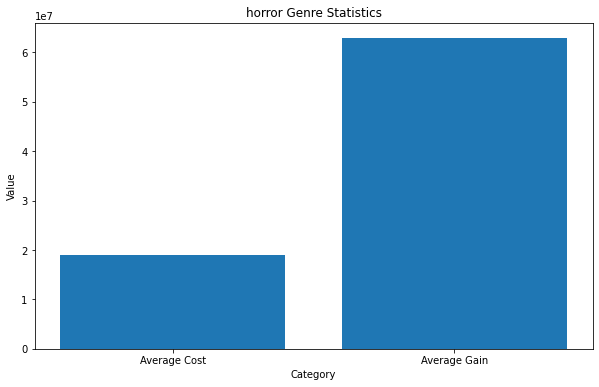

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(horror_data['Category'], horror_data['Value'])
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('horror Genre Statistics')
plt.show()

## Then, Copy/Paste the Code Blocks for 'Documentary'

In [34]:
Documentary_df = movie_basics[movie_basics['genres'].str.contains('Documentary', case=False)]
Documentary_df = Documentary_df.loc[:, ['movie', 'genres']]
def keep_only_drama(genres):
    genre_list = genres.split(',')
    if 'Documentary' in genre_list:
        return 'Documentary'
    else:
        return ','.join(genre_list)

Documentary_df['genres'] = Documentary_df['genres'].apply(keep_only_drama)
Documentary_df['genres'] = Documentary_df['genres'].str.lower()
Documentary_df['movie'] = Documentary_df['movie'].str.lower()
Documentary_df

,movie,genres
8,o silêncio,documentary
12,cooper and hemingway: the true gen,documentary
14,t.g.m. - osvoboditel,documentary
24,akakis mogzauroba,documentary
25,seven jews from my class,documentary
...,...,...
146133,the mystery of a buryat lama,documentary
146134,drømmeland,documentary
146136,illenau - die geschichte einer ehemaligen heil...,documentary
146140,rodolpho teóphilo - o legado de um pioneiro,documentary


In [35]:
Documentary_cost = Documentary_df.merge(movie_budgetsCLEAN[['movie', 'production_budget']], on='movie', how='inner')
Documentary_cost['production_budget'] = Documentary_cost['production_budget'].astype(int)

In [36]:
Documentary_cost_mean = Documentary_cost['production_budget'].mean()
Documentary_cost_mean

25291082.095238097

In [37]:
Documentary_gain = Documentary_df.merge(movie_budgetsCLEAN[['movie', 'worldwide_gross']], on='movie', how='inner')
Documentary_gain['worldwide_gross'] = Documentary_gain['worldwide_gross'].astype('int64')

In [38]:
Documentary_gain_mean= Documentary_gain['worldwide_gross'].mean()
Documentary_gain_mean

63110617.69246032

In [39]:
Documentary_roi = ((Documentary_gain_mean - Documentary_cost_mean) / Documentary_cost_mean) * 100
Documentary_roi

149.53704018992147

In [40]:
Documentary_data = {'Genre': ['Documentary'],
        'Average Cost': [Documentary_cost_mean],
        'Average Gain': [Documentary_gain_mean],}
Documentary_data = pd.DataFrame({'Category': ['Average Cost', 'Average Gain'], 'Value': [Documentary_cost_mean, Documentary_gain_mean]})

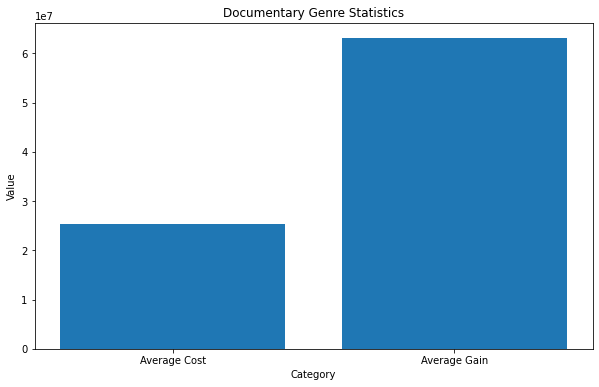

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(Documentary_data['Category'], Documentary_data['Value'])
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Documentary Genre Statistics')
plt.show()

# Comparing Movie Popularity with Total Title Words 

## Starting by Pulling the TMDB Dataset, then Cleaning

In [42]:
def remove_punctuation(text):
    return text.str.replace('[{}]'.format(string.punctuation), '')

tmdb_moviesCLEAN['movieNAME'] = remove_punctuation(tmdb_moviesCLEAN['movieNAME'])

# Print the updated DataFrame
tmdb_moviesCLEAN

,Unnamed: 0,genre_ids,id,original_language,movieNAME,popularity,release_date,title,vote_average,vote_count
0,0,adventure fantasy family,12444,en,harry potter and the deathly hallows part 1,33.533,2010-11-19,harry potter and the deathly hallows: part 1,7.7,10788
1,1,fantasy adventure animation family,10191,en,how to train your dragon,28.734,2010-03-26,how to train your dragon,7.7,7610
2,2,adventure action science fiction,10138,en,iron man 2,28.515,2010-05-07,iron man 2,6.8,12368
3,3,animation comedy family,862,en,toy story,28.005,1995-11-22,toy story,7.9,10174
4,4,action science fiction adventure,27205,en,inception,27.92,2010-07-16,inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,horror drama,488143,en,laboratory conditions,0.6,2018-10-13,laboratory conditions,0.0,1
26513,26513,drama thriller,485975,en,exhibit84xxx,0.6,2018-05-01,_exhibit_84xxx_,0.0,1
26514,26514,fantasy action adventure,381231,en,the last one,0.6,2018-10-01,the last one,0.0,1
26515,26515,family adventure action,366854,en,trailer made,0.6,2018-06-22,trailer made,0.0,1


In [43]:
# Make a new column, containing the count of space characters, per movie title
tmdb_moviesCLEAN['Twords'] = tmdb_moviesCLEAN['movieNAME'].str.count(' ')

In [44]:
# Pull the 'popularity' and 'Twords' columns into a new dataframe
Extract = ['popularity', 'Twords']
Words_per_pop = tmdb_moviesCLEAN[Extract]

# Add 1 across Twords to account, because spaces were counted, not actual words
Words_per_pop['Twords'] += 1
# Convert 'Twords' to float, so it can be calculated with 'popularity' values
Words_per_pop['popularity'] = Words_per_pop['popularity'].astype(float)
Words_per_pop

,popularity,Twords
0,33.533,8
1,28.734,5
2,28.515,3
3,28.005,2
4,27.920,1
...,...,...
26512,0.600,2
26513,0.600,1
26514,0.600,3
26515,0.600,2


In [45]:
# Calculate the mean popularity for unique values of 'Twords'
Title_Count = Words_per_pop.groupby('Twords')['popularity'].mean().reset_index()

# Transpose the dataframe to have 'Twords' as columns
Title_Count = Title_Count.set_index('Twords').T
Title_Count

Twords,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,21,25,26,31
popularity,3.722437,3.331634,3.037892,2.890077,2.870612,2.529167,2.37613,2.31466,1.594716,1.444427,...,1.006167,1.763154,1.505833,1.423,0.84,0.6,0.6,0.6,0.909,0.6


In [46]:
# Drop columns where the column names are greater than 10 (for more efficient readability)
Title_Count = Title_Count.drop(columns=Title_Count.columns[Title_Count.columns.astype(int) > 10])
Title_Count

Twords,1,2,3,4,5,6,7,8,9,10
popularity,3.722437,3.331634,3.037892,2.890077,2.870612,2.529167,2.37613,2.31466,1.594716,1.444427


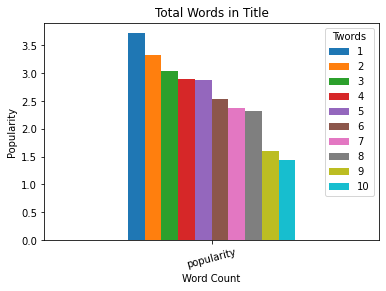

In [47]:
Title_Count.plot(kind='bar')

plt.xlabel('Word Count')
plt.xticks(rotation=15)

plt.ylabel('Popularity')

plt.title('Total Words in Title')

plt.show()